# Kaggle Titanic Data Challenge

This notebook uses logistic regression to tackle the Kaggle Titanic Data Challenge. Through an initial visualization an understanding of the relationships between the features is gained and the algorithm is then implemented. This is followed by a bias vs variance plot to ensure that the algorithm is doing what it is meant to. Finally, we print predictions to a text file which can directly be uploaded to Kaggle.

PS: I may have gone a tiny bit overboard on the visualizations

In [1]:
%matplotlib inline
import re
import csv
import pandas
import numpy as np
from math import isnan
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

## Data Preprocessing

### Read Train and Test Data

Read the training dataset into a pandas dataframe and shuffle it. We specify the state from which to shuffle so that the same result is produced every time this code is run.

In [2]:
input_file_train_cross = "train.csv"
df1 = pandas.read_csv(input_file_train_cross)
df1 = df1.sample(frac=1, random_state=50).reset_index(drop=True) #ensures duplicability (it is a word)
labels = df1.Survived

input_file_test = "test.csv"
test_df = pandas.read_csv(input_file_test)
df1 = pandas.concat([df1, test_df])

df2 = pandas.DataFrame()
test_passenger_ids = test_df.PassengerId

### Prepare Features

The first feature we will deal with is the Salutations of people on the ship. We will one-hot encode categories of salutations as defined by the Title_Dictionary dictionary in the interest of not adding 18 additional features.

In [3]:
#Salutations #1
#df1['Salutation'] = df1.Name.map(lambda x: re.split(' ',re.split(',', x)[1].lstrip())[0])
df1['Salutation'] = df1.Name.map(lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
#salutations = df1.Name.map(lambda x: re.split(' ',re.split(',', x)[1].lstrip())[0])
salutations = df1.Name.map(lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
#for salutation in salutations.unique():
#    salutation_key = 'salutation_'+salutation
#    df2[salutation_key] = salutations.map(lambda x: 1 if x==salutation else 0)

Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }

#salutations = salutations.map(Title_Dictionary)
df2 = pandas.get_dummies(salutations, prefix = 'sal')
#salutations_visualisation = pandas.concat([train_labels, df2], axis=1)

Some passengers had multiple names, in all probability indicating maiden and married names, we parse this number into number_of_names. We then one-hot encode the ticket classes of the passengers and the locations they embarked the ship on. 

We then proceed to add age as an additional parameter and where the data is incomplete, we add the mean values of the age for the salutation of an individual. 

This is again followed by one-hot-encoding of the first letter of the cabins as this is indicative of the location of the cabin.

Similar to the process for adding of age as a feature we then add the fare. Incomplete values are again determined by the mean values for a particular passenger class.

Siblings and Spouses (Spice?), Parents and Children, and the Sex of the passengers are then added as features to df2.

In [4]:
#Names PreProcess
names = df1.Name.map(lambda x: re.split('\(|\)', x))
first_name = names.map(lambda x: [y for y in x if y.replace(" ","") !=  ''])

#Number of Words in Name
#number_of_words = names.map(lambda x: len(re.split(' ',x[0])))
#df1['number_of_words'] = number_of_words

#No. of Names
number_of_names = first_name.map(lambda x: len(x))
df2['number_of_names'] = number_of_names

#PClass
for a_class in df1.Pclass.unique():
    if(pandas.isnull(a_class) == False):
        class_key = 'p_class_' + str(a_class)
    else:
        raise ValueError
    df2[class_key] = df1.Pclass.map(lambda x: 1 if x==a_class else 0)

#Embarked
for location in df1.Embarked.unique():
    if(pandas.isnull(location) == False):
        location_key = 'location_' + location
        df2[location_key] = df1.Embarked.map(lambda x: 1 if x == location else 0)

#Age
title_mean_age = pandas.pivot_table(df1, values = 'Age', columns='Salutation', aggfunc='mean')
df2['Age'] = df1.apply(lambda x: title_mean_age[x['Salutation']] if pandas.isnull(x['Age']) else x['Age'], axis = 1)

#Cabin
cabins = df1.Cabin.map(lambda x: str(x)[0] if len(str(x))>0 else 0)
for cabin in cabins.unique():
    if(pandas.isnull(cabin) == False):
        cabin_key = 'cabin_' + cabin
    else:
        cabin_key = 'cabin_unknown'
    df2[cabin_key] = cabins.map(lambda x: 1 if x==cabin else 0)

#Fare
pclass_mean_fare = pandas.pivot_table(df1, values='Fare', columns='Pclass', aggfunc='mean')
df2['Fare'] = df1.apply(lambda x: pclass_mean_fare[x['Pclass']] if pandas.isnull(x['Fare']) else x['Fare'], axis =1)

#SibSp and Parch
df2['SibSp'] = df1.SibSp
df2['Parch'] = df1.Parch

#Sex
df2['Sex'] = df1.Sex.map(lambda x: 0 if x =='male' else 1)

## Visualisation

### Correlation Heat Map

A heatmap to determine the correlation between the different features.

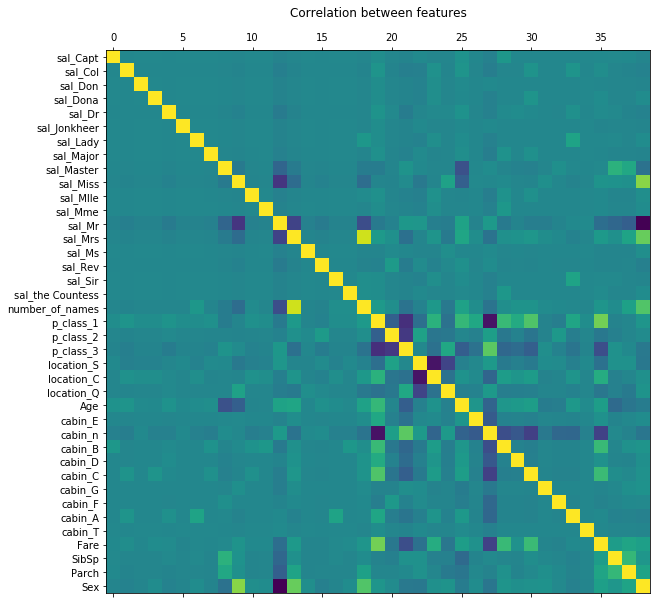

In [5]:
corr = df2.corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
ax.set_title("Correlation between features")
plt.yticks(range(len(corr.columns)), corr.columns);
plt.show()

### Age and Sex vs Survival

In [6]:
visualisation_dataset = df2.iloc[:891, :]
visualisation_labels = labels

We plot the percentage of passengers who survived versus the age distinct for male and females. Similarly we plot the count survived vs age.

We then plot the percentage survived against the various salutations, not our groupings but the original salutations.

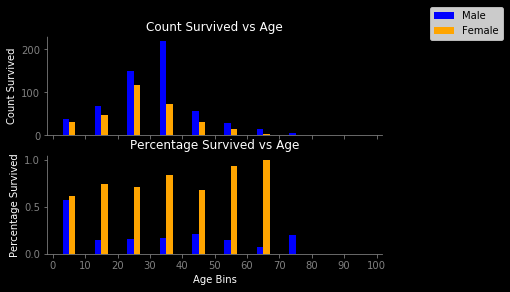

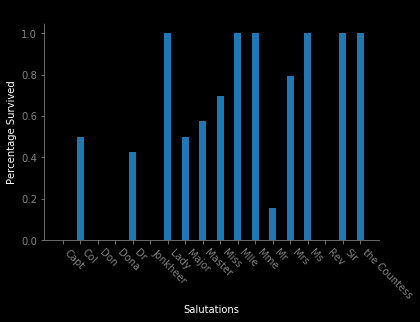

In [7]:
blue_patch = mpatches.Patch(color='blue', label='Male')
orange_patch = mpatches.Patch(color='orange', label='Female')
binned_age, bins = pandas.cut(visualisation_dataset.Age, np.arange(0, 101, 10), retbins=True)
d = {'age':binned_age, 'sex': visualisation_dataset.Sex, 'survived': visualisation_labels}
age_sex = pandas.DataFrame(d)
fig, [ax0, ax1] = plt.subplots(nrows=2, ncols=1, sharex=True)

#Percentage Survived vs Age
d_male_mean = age_sex[age_sex.sex == 0].drop('sex', 1).groupby(['age']).mean().reset_index()
d_female_mean = age_sex[age_sex.sex == 1].drop('sex', 1).groupby(['age']).mean().reset_index()
rects1 = ax1.bar([0.6,2.6,4.6,6.6,8.6,10.6,12.6,14.6, 16.6, 18.6],  d_male_mean.survived, width=0.4, color='b', align='edge', label='Male')
rects2 = ax1.bar([1,3,5,7,9,11,13,15, 17, 19],  d_female_mean.survived, width=0.4, color='orange', align='edge', label='Female')
ax1.set_xlabel('Age Bins', color='white')
ax1.set_ylabel('Percentage Survived', color='white')
ax1.set_xticks([0,2,4,6,8,10,12,14,16, 18, 20])
ax1.set_xticklabels(bins)
ax1.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
ax1.tick_params(colors='grey')
ax1.set_title('Percentage Survived vs Age', color = 'white')
ax1.set_facecolor('black')
ax1.spines['left'].set_color('grey')
ax1.spines['bottom'].set_color('grey')

#Count Survived vs Age
d_male_count = age_sex[age_sex.sex == 0].drop('sex', 1).groupby(['age']).count().reset_index()
d_female_count = age_sex[age_sex.sex == 1].drop('sex', 1).groupby(['age']).count().reset_index()
rects3 = ax0.bar([0.6,2.6,4.6,6.6,8.6,10.6,12.6,14.6, 16.6, 18.6],  d_male_count.survived, width=0.4, color='b', align='edge', label='Male')
rects4 = ax0.bar([1,3,5,7,9,11,13,15, 17, 19],  d_female_count.survived, width=0.4, color='orange', align='edge', label='Female')
#ax0.set_xlabel('Age Bins', color='white')
ax0.set_ylabel('Count Survived', color='white')
#ax0.set_xticks([0,2,4,6,8,10,12,14,16, 18, 20])
#ax0.set_xticklabels(bins)
#ax0.legend()
ax0.tick_params(colors='grey')
ax0.set_title('Count Survived vs Age', color='white')
ax0.set_facecolor('black')
ax0.spines['left'].set_color('grey')
ax0.spines['bottom'].set_color('grey')

#Percentage Survived vs Title
fig1, ax = plt.subplots()
salutation_list = visualisation_dataset.columns.values[np.core.defchararray.startswith(visualisation_dataset.columns.values.astype('U'), 'sal')]
salutations_visualisation = pandas.concat([visualisation_dataset, visualisation_labels], axis=1)
count_list =[]
for individual_salutation in salutation_list:
    count_list.append(salutations_visualisation.loc[salutations_visualisation[individual_salutation] == 1].Survived.mean())
ax.bar(np.arange(1, len(count_list)*2 +1, 2), count_list)
ax.set_xlabel('Salutations', color='white')
ax.set_ylabel('Percentage Survived', color='white')
ax.set_xticks(np.arange(1, len(count_list)*2 + 1, 2))
sal_ticks = [x[4:] for x in salutation_list]
#print np.apply_along_axis(m, 0, salutation_list)
ax.set_xticklabels(sal_ticks, ha='left', rotation=-45)
ax.tick_params(colors='grey', direction='out')
ax.set_title('Percentage Survived vs Title')
ax.set_facecolor('black')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

fig.set_facecolor('black')
#fig.set_tight_layout(True)
fig1.set_facecolor('black')
#fig1.set_tight_layout(True)
plt.show()

## Additional Feature and Data Preparation

### Feature Scaling

Straight forward feature scaling for efficient training of the model.

In [8]:
df2 = (df2 - df2.mean()) / (df2.max() - df2.min())

### Splitting the Data into DataSets

In [9]:
train_dataset_size = 691
cv_dataset_size = 200
train_dataset = df2.iloc[:train_dataset_size, :]
train_labels = labels.iloc[:train_dataset_size]
cv_dataset = df2.iloc[train_dataset_size:train_dataset_size+cv_dataset_size, :]
cv_labels = labels.iloc[train_dataset_size:train_dataset_size+cv_dataset_size]
test_dataset = df2.iloc[train_dataset_size+cv_dataset_size:, :]

## Sanity Check

### Bias vs Variance Analysis

We plot curves for the bias and variance to determine the ideal value of lambda (regularization parameter) as well as to ensure that our model responds as we want it to for different values of C where C = 1/lambda.

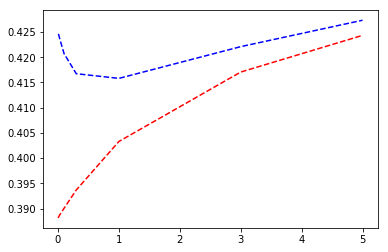

In [10]:
values_of_lambda = np.sort(np.array([0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 5]))
values_of_c = 1/values_of_lambda
train_cost = []
valid_cost = []
other_vs_of_c = []
for c in values_of_c:
    logreg = LogisticRegression(C=c)
    logreg.fit(train_dataset, train_labels)
    train_cost.append(log_loss(train_labels, logreg.predict_proba(train_dataset)))
    valid_cost.append(log_loss(cv_labels, logreg.predict_proba(cv_dataset)))
    #train_cost.append(logreg.score(train_X, train_Y))
    #valid_cost.append(logreg.score(valid_X, valid_Y))
    #train_cost.append(_logistic_loss(logreg.coef_.ravel(), train_X.iloc[:391,:], train_Y.iloc[:391], c))
    #valid_cost.append(_logistic_loss(logreg.coef_.ravel(), valid_X, valid_Y, c))
plt.plot(values_of_lambda, train_cost, 'r--', label='Train Set')
plt.plot(values_of_lambda, valid_cost, 'b--', label='CV Set')
plt.show()

## Algorithm Scoring

In [11]:
C = 1
logreg = LogisticRegression(C=C)
logreg.fit(train_dataset, train_labels)
score = logreg.score(cv_dataset, cv_labels)
print("The score is: ", score)

('The score is: ', 0.82499999999999996)


## Test Prediction

### Write Prediction

In [12]:
predictions = logreg.predict(test_dataset)
predictions_series = pandas.Series(predictions)
results_df = pandas.DataFrame({'PassengerId' : test_passenger_ids,
                               'Survived': predictions_series})
results_df.to_csv('predictions.csv', index=False)